### Building the model  
We will now focus on building the model. Let's briefly go through what we will do next.  
1. Define the inputs and outputs
2. Define the weights
3. Define the loss function
4. Define the optimizer
5. Evaluate our model

In [1]:
from __future__ import absolute_import # use absolute import instead of relative import

# '/' for floating point division, '//' for integer division
from __future__ import division  
from __future__ import print_function  # use 'print' as a function

import os

import numpy as np
import tensorflow as tf

from process_data import make_dir, download, read_data, build_vocab, convert_words_to_index, process_data, generate_sample, get_batch, get_batch_gen


/Users/unahsu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class SkipGramModel:
    """ Build the graph for word2vec model """
    def __init__(self, hparams=None):

        if hparams is None:
            self.hps = get_default_hparams()
        else:
            self.hps = hparams

        # define a variable to record training progress
        self.global_step = tf.Variable(
            0, dtype=tf.int32, trainable=False, name='global_step')

    def _create_input(self):
        """ Step 1: define input and output """

        with tf.name_scope("data"):
            self.centers = tf.placeholder(tf.int32, [self.hps.num_pairs], name='centers')
            self.targets = tf.placeholder(tf.int32, [self.hps.num_pairs, 1], name='targets')
            dataset = tf.data.Dataset.from_tensor_slices((self.centers, self.targets))
            dataset = dataset.repeat() # Repeat the input indefinitely
            dataset = dataset.batch(self.hps.batch_size)

            self.iterator = dataset.make_initializable_iterator()  # create iterator
            self.center_words, self.target_words = self.iterator.get_next()

    def _create_embedding(self):
        """
        Step 2: define weights. 
        In word2vec, it's actually the weights that we care about
        """
        with tf.device('/cpu:0'):
            with tf.name_scope("embed"):
                self.embed_matrix = tf.Variable(
                    tf.random_uniform([self.hps.vocab_size, #10000X128
                                       self.hps.embed_size], -1.0, 1.0),
                    name='embed_matrix')

    def _create_loss(self):
        """ Step 3 + 4: define the model + the loss function """
        with tf.device('/cpu:0'):
            with tf.name_scope("loss"):
                # Step 3: define the inference
                embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

                # Step 4: define loss function
                # construct variables for NCE loss
                nce_weight = tf.Variable(
                    tf.truncated_normal([self.hps.vocab_size, self.hps.embed_size],
                                        stddev=1.0 / (self.hps.embed_size ** 0.5)),
                    name='nce_weight')
                nce_bias = tf.Variable(tf.zeros([self.hps.vocab_size]), name='nce_bias')

                # define loss function to be NCE loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                          biases=nce_bias,
                                                          labels=self.target_words,
                                                          inputs=embed,
                                                          num_sampled=self.hps.num_sampled,
                                                          num_classes=self.hps.vocab_size),
                                           name='loss')

    def _create_optimizer(self):
        """ Step 5: define optimizer """
        with tf.device('/cpu:0'):
            self.optimizer = tf.train.AdamOptimizer(self.hps.lr).minimize(
                self.loss, global_step=self.global_step)

    def _build_nearby_graph(self):
        # Nodes for computing neighbors for a given word according to their cosine distance.
        self.nearby_word = tf.placeholder(dtype=tf.int32)  # word id
        
        nemb = tf.nn.l2_normalize(self.embed_matrix, 1)
        nearby_emb = tf.gather(nemb, self.nearby_word)
        nearby_dist = tf.matmul(nearby_emb, nemb, transpose_b=True)
        self.nearby_val, self.nearby_idx = tf.nn.top_k(nearby_dist, min(1000, self.hps.vocab_size))

    def _build_eval_graph(self):
        """Build the eval graph.
        Eval graph

        Each analogy task is to predict the 4th word (d) given three words: a, b, c.  E.g., a=italy, b=rome, c=france,
        we should predict d=paris.

        The eval feeds three vectors of word ids for a, b, c, 
        each of which is of size N, where N is the number of analogies we want to evaluate in one batch.
        """
        self.analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
        self.analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
        self.analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

        # Normalized word embeddings of shape [vocab_size, emb_dim].
        nemb = tf.nn.l2_normalize(self.embed_matrix, 1)

        # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
        # They all have the shape [N, emb_dim]
        a_emb = tf.gather(nemb, self.analogy_a)  # a's embs
        b_emb = tf.gather(nemb, self.analogy_b)  # b's embs
        c_emb = tf.gather(nemb, self.analogy_c)  # c's embs

        # We expect that d's embedding vectors on the unit hyper-sphere is near:
        # c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
        target = c_emb + (b_emb - a_emb)

        # Compute cosine distance between each pair of target and vocab.
        # dist has shape [N, vocab_size].
        dist = tf.matmul(target, nemb, transpose_b=True)

        # For each question (row in dist), find the top 20 words.
        _, self.pred_idx = tf.nn.top_k(dist, 20)

    def predict(self, sess, analogy):
        """ Predict the top 20 answers for analogy questions """
        idx, = sess.run([self.pred_idx], {
            self.analogy_a: analogy[:, 0],
            self.analogy_b: analogy[:, 1],
            self.analogy_c: analogy[:, 2]
        })
        return idx

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_input()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._build_eval_graph()
        self._build_nearby_graph()
        self._create_summaries()

def train_model(sess, model, batch_gen, index_words, num_train_steps):
    saver = tf.train.Saver()
    # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    initial_step = 0
    make_dir('checkpoints1') # directory to store checkpoints

    sess.run(tf.global_variables_initializer()) # initialize all variables
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints1/checkpoint'))
    # if that checkpoint exists, restore from checkpoint
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    total_loss = 0.0 # use this to calculate late average loss in the last SKIP_STEP steps
    writer = tf.summary.FileWriter('graph/lr' + str(model.hps.lr), sess.graph)
    initial_step = model.global_step.eval()
    for index in range(initial_step, initial_step + num_train_steps):
        # feed in new dataset  
        if index % model.hps.new_dataset_every == 0:
            try:
                centers, targets = next(batch_gen)
            except StopIteration: # generator has nothing left to generate
                batch_gen = get_batch_gen(index_words, 
                                          model.hps.skip_window, 
                                          model.hps.num_pairs)
                centers, targets = next(batch_gen)
                print('Finished looking at the whole text')
            
            feed = {
                model.centers: centers,
                model.targets: targets
            }
            _ = sess.run(model.iterator.initializer, feed_dict = feed)
            print('feeding in new dataset')

        loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op])
        writer.add_summary(summary, global_step=index)
        total_loss += loss_batch
        if (index + 1) % model.hps.skip_step == 0:
            print('Average loss at step {}: {:5.1f}'.format(
                                                  index, total_loss/model.hps.skip_step))
            total_loss = 0.0
            saver.save(sess, 'checkpoints1/skip-gram', index)

def get_default_hparams():
    hparams = tf.contrib.training.HParams(
        num_pairs = 10**6,                # number of (center, target) pairs in each dataset instance
        vocab_size = 10000,
        batch_size = 128,
        embed_size = 300,                 # dimension of the word embedding vectors
        skip_window = 3,                  # the context window
        num_sampled = 100,                # number of negative examples to sample
        lr = 0.005,                       # learning rate
        new_dataset_every = 10**4,        # replace the original dataset every ? steps
        num_train_steps = 2*10**5,        # number of training steps for each feed of dataset
        skip_step = 2000
    )
    return hparams

def main():
    hps = get_default_hparams()
    index_words, dictionary, index_dictionary = process_data(hps.vocab_size)
    batch_gen = get_batch_gen(index_words, hps.skip_window, hps.num_pairs)

    model = SkipGramModel(hparams = hps)
    model.build_graph()
  
    with tf.Session() as sess:

        # feed the model with dataset
        centers, targets = next(batch_gen)
        feed = {
            model.centers: centers,
            model.targets: targets
        }
        sess.run(model.iterator.initializer, feed_dict = feed) # initialize the iterator

        train_model(sess, model, batch_gen, index_words, hps.num_train_steps)

if __name__ == '__main__':
    main()

Dataset ready
feeding in new dataset
Average loss at step 1999:  75.7
Average loss at step 3999:  17.1
Average loss at step 5999:  10.3
Average loss at step 7999:   8.8
Average loss at step 9999:   6.7
feeding in new dataset
Average loss at step 11999:   8.2
Average loss at step 13999:   7.6
Average loss at step 15999:   7.6
Average loss at step 17999:   7.1
Average loss at step 19999:   6.1
feeding in new dataset
Average loss at step 21999:   7.2
Average loss at step 23999:   6.9
Average loss at step 25999:   6.7
Average loss at step 27999:   6.3
Average loss at step 29999:   6.1
feeding in new dataset
Average loss at step 31999:   6.4
Average loss at step 33999:   6.3
Average loss at step 35999:   6.6
Average loss at step 37999:   6.6
Average loss at step 39999:   5.6
feeding in new dataset
Average loss at step 41999:   6.7
Average loss at step 43999:   6.7
Average loss at step 45999:   6.4
Average loss at step 47999:   6.4
Average loss at step 49999:   5.9
feeding in new dataset
Ave

In [3]:
import os
import tensorflow as tf
from process_data import process_data
from train import get_default_hparams, SkipGramModel

#Clears the default graph stack and resets the global default graph
tf.reset_default_graph() 
hps = get_default_hparams()

# get dictionary 
index_words, dictionary, index_dictionary = process_data(hps.vocab_size)

# build model
model = SkipGramModel(hps)
model.build_graph()

# initialize variables and restore checkpoint
config = tf.ConfigProto(allow_soft_placement = True, log_device_placement = True)
sess = tf.InteractiveSession(config = config)
init = tf.global_variables_initializer() # an operation that initializes all variables
sess.run(init) # run the init operation with session

saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints1/checkpoint'))
saver.restore(sess, ckpt.model_checkpoint_path)

Dataset ready
INFO:tensorflow:Restoring parameters from checkpoints1/skip-gram-199999


In [4]:
import numpy as np

def nearby(words, model, sess, dictionary, index_dictionary, num=20):
    """Prints out nearby words given a list of words."""
    ids = np.array([dictionary.get(x, 0) for x in words])
    vals, idx = sess.run(
        [model.nearby_val, model.nearby_idx], {model.nearby_word: ids})
    for i in range(len(words)):
        print("\n%s\n=====================================" % (words[i]))
        for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
            print("%-20s %6.4f" % (index_dictionary.get(neighbor), distance))
        
def analogy(line, model, sess, dictionary, index_dictionary):
    """ Prints the top k anologies for a given array which contain 3 words"""
    analogy = np.array([dictionary.get(w, 0) for w in line])[np.newaxis,:]
    idx = model.predict(sess, analogy)
    print(line)
    for i in idx[0]:
        print(index_dictionary[i])

In [5]:
words = ['machine', 'learning']
nearby(words, model, sess, dictionary, index_dictionary)


machine
machine              1.0000
expand               0.2230
distant              0.2191
enables              0.2184
grt                  0.2167
amplifier            0.2166
libertarian          0.2162
define               0.2134
entities             0.2083
byte                 0.2040
conversation         0.2024
finds                0.2016
anarchism            0.2009
governors            0.2004
attached             0.1991
varied               0.1978
devices              0.1976
lack                 0.1971
theatrical           0.1965
periodic             0.1962

learning
learning             1.0000
amplifiers           0.2685
implementation       0.2555
basel                0.2347
loving               0.2338
satire               0.2303
blackadder           0.2298
dancer               0.2291
terrorism            0.2285
ada                  0.2278
favourite            0.2256
babe                 0.2225
blake                0.2225
fund                 0.2222
providing            0.2206
i

In [6]:
analogy(['london', 'england', 'berlin'], model, sess, dictionary, index_dictionary)

['london', 'england', 'berlin']
berlin
england
hundreds
phoenix
pulling
enjoyed
chips
fleming
jonathan
methodist
partner
arabian
passes
verbs
interested
yugoslavia
athenian
parker
isotopes
keith


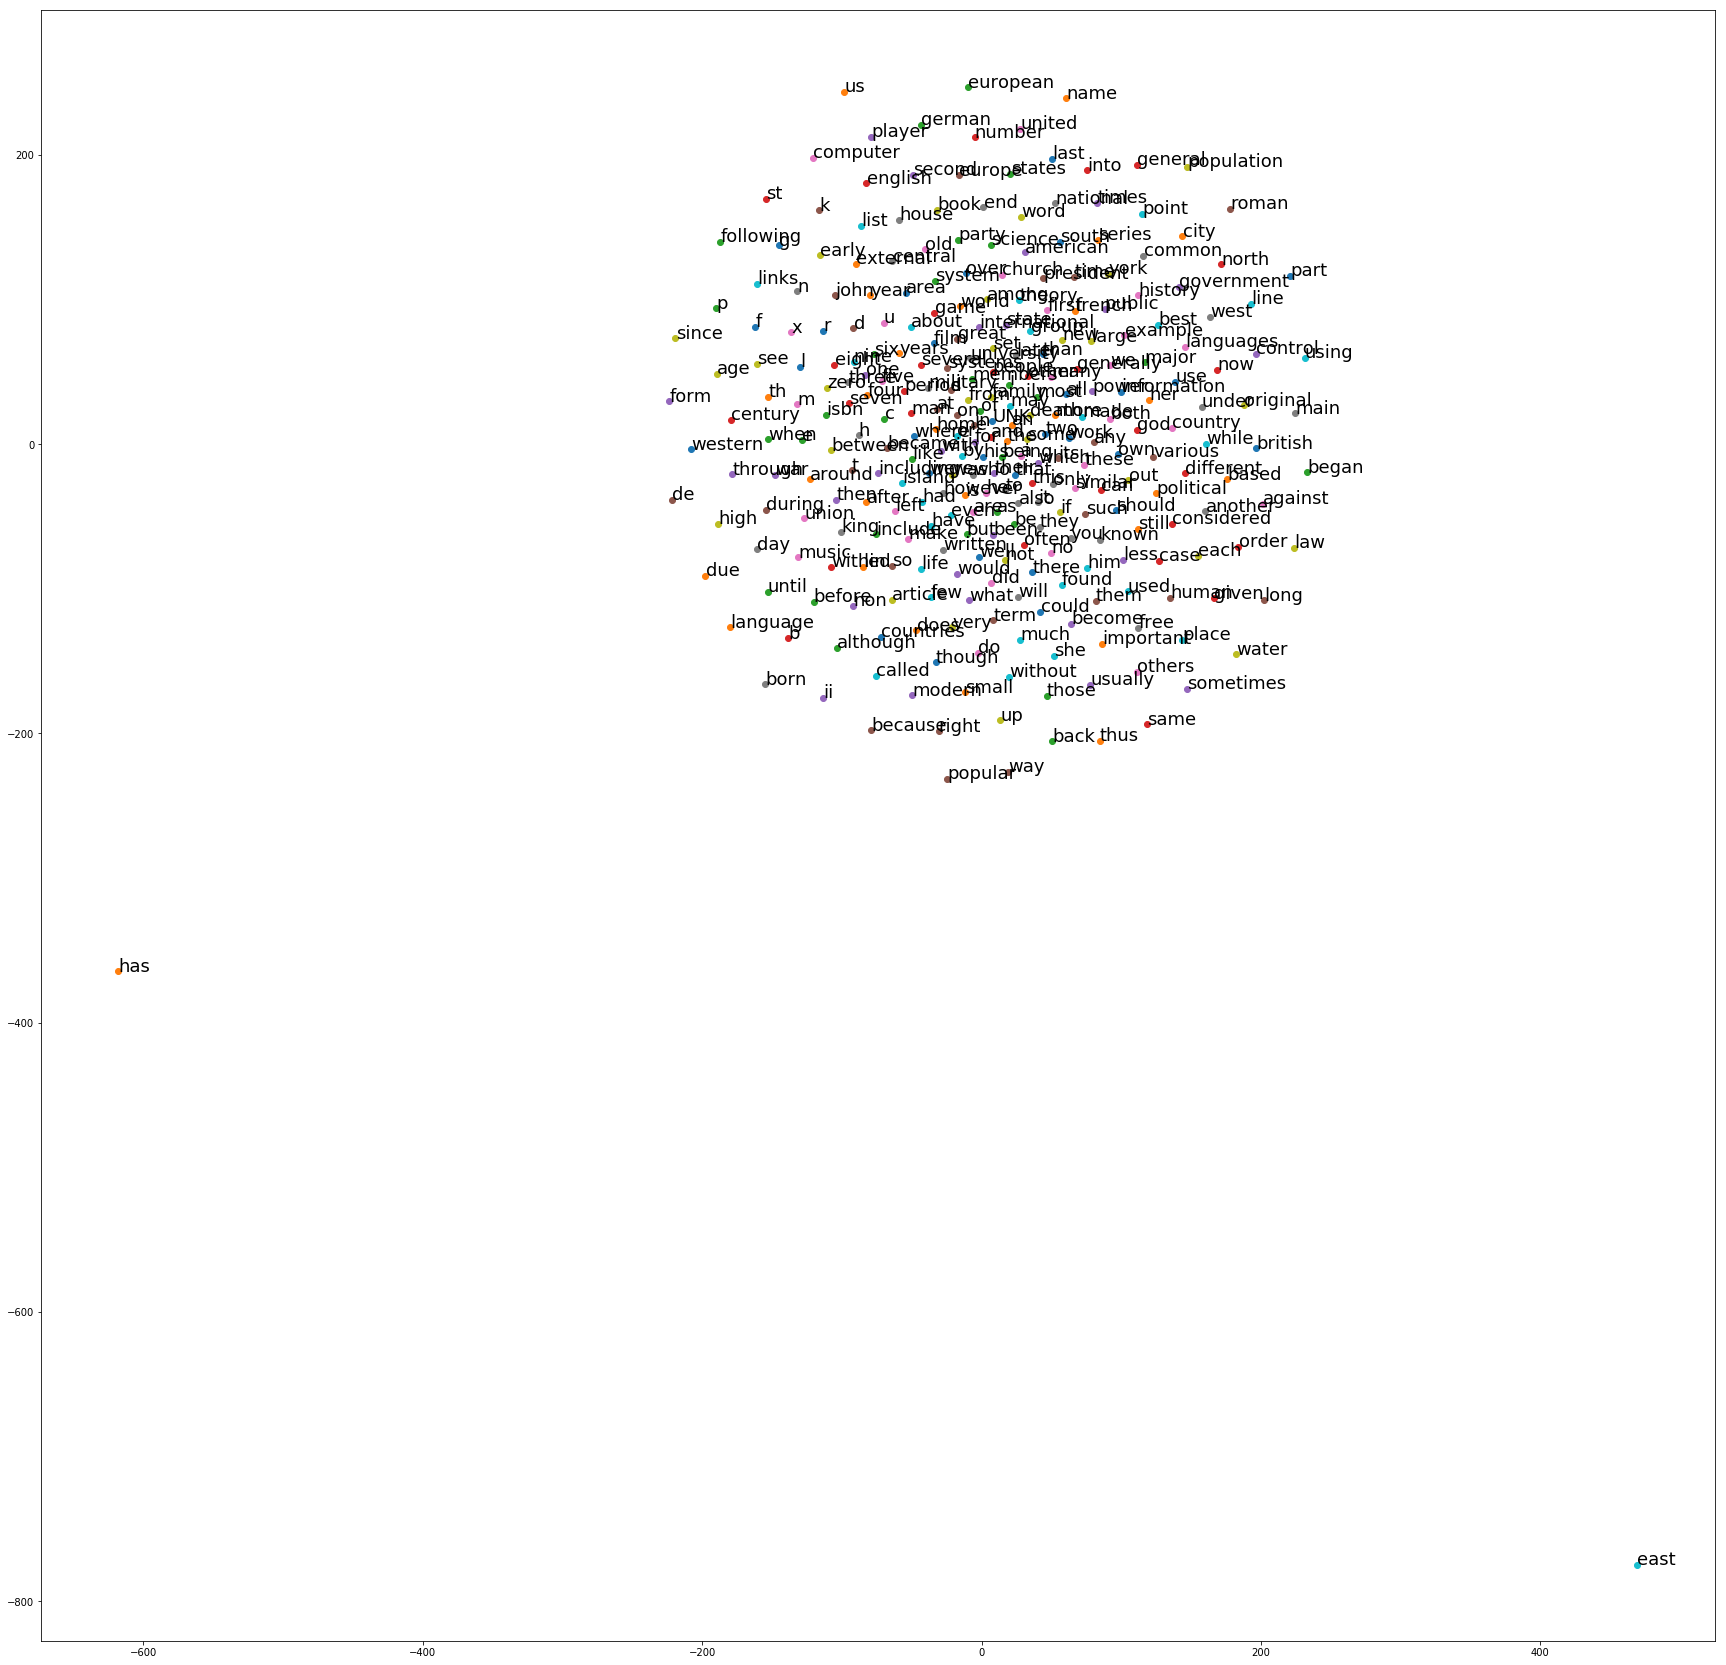

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

rng = 300

embed_matrix = sess.run(model.embed_matrix) # get the embed matrix

X_embedded = TSNE(n_components=2).fit_transform(embed_matrix[:rng])

plt.figure(figsize=(30,30))

for i in range(rng):
    plt.scatter(X_embedded[i][0], X_embedded[i][1])
    plt.text(X_embedded[i][0]+0.2,
             X_embedded[i][1]+0.2,
             index_dictionary.get(i, 0), fontsize=18)

plt.show()